In [1]:
import os
import trimesh
import shutil
import concurrent.futures
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import utils

if torch.cuda.is_available():
    torch.set_default_device('cuda')
    torch.set_float32_matmul_precision('high')
    print(torch.cuda.get_device_properties(torch.cuda.current_device()))


_CudaDeviceProperties(name='Radeon RX 7900 XTX', major=11, minor=0, total_memory=24560MB, multi_processor_count=48)


In [11]:
# Set our working directory based on whether we are in Google Colab or not
BASE_DIR = '/content/drive/MyDrive/colab/aai/' if 'google.colab' in str(get_ipython()) else './'

DATA_DIR = os.path.join(BASE_DIR, 'data')
TEMP_DIR = os.path.join(BASE_DIR, 'temp')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

# Number of points to sample from the mesh
NUM_POINTS = 2048

def convert_and_save_mesh_as_point_cloud(mesh_path, out_path):
    mesh = trimesh.load(mesh_path)
    point_cloud = mesh.sample(NUM_POINTS)
    # Center the point cloud
    point_cloud = point_cloud - mesh.centroid
    # Scale the point cloud
    point_cloud = point_cloud / np.max(np.abs(point_cloud))
    trimesh.PointCloud(point_cloud).export(out_path)


def download_and_prepare_data_modelnet40():
    # Download and extract the ModelNet40 dataset
    utils.download_and_extract_archive(
        "https://lmb.informatik.uni-freiburg.de/resources/datasets/ORION/modelnet40_manually_aligned.tar",
        download_root=TEMP_DIR,
        remove_finished=True
    )

    # Let's take a look at the airplane class
    airplane_meshes_dir = os.path.join(TEMP_DIR, 'airplane') 
    display(trimesh.load(os.path.join(airplane_meshes_dir, 'train', 'airplane_0201.off')).show())

    os.makedirs(DATA_DIR, exist_ok=True)
    os.makedirs(TRAIN_DIR, exist_ok=True)
    os.makedirs(VAL_DIR, exist_ok=True)
    # Convert train meshes to point clouds
    train_in_dir = os.path.join(airplane_meshes_dir, 'train')
    train_in_files = Path(train_in_dir).glob('*.off')
    with concurrent.futures.ProcessPoolExecutor() as executor_train:
        for path in train_in_files:
            out_path = os.path.join(TRAIN_DIR, f"{path.stem}.ply")
            executor_train.submit(convert_and_save_mesh_as_point_cloud, path, out_path)
    
    
    # Convert validation meshes to point clouds
    val_in_dir = os.path.join(airplane_meshes_dir, 'test')
    val_in_files = Path(val_in_dir).glob('*.off')
    with concurrent.futures.ProcessPoolExecutor() as executor_val:
        for path in val_in_files:
            out_path = os.path.join(VAL_DIR, f"{path.stem}.ply")
            executor_val.submit(convert_and_save_mesh_as_point_cloud, path, out_path)
    
    # Remove the temporary directory
    shutil.rmtree(TEMP_DIR)


def download_and_prepare_data_shape_net_core():
    # Download and extract the ShapeNetCore training dataset
    utils.download_and_extract_archive(
        "http://shapenet.cs.stanford.edu/shapenet/obj-zip/SHREC16/train.zip",
        download_root=TEMP_DIR,
        remove_finished=True
    )

    os.makedirs(DATA_DIR, exist_ok=True)
    os.makedirs(TRAIN_DIR, exist_ok=True)
    os.makedirs(VAL_DIR, exist_ok=True)

    # Let's take a look at the airplane class
    train_meshes_dir = os.path.join(TEMP_DIR, "train", "02691156") 
    display(trimesh.load(os.path.join(train_meshes_dir, "model_048361.obj")).show())

    # Convert train meshes to point clouds
    train_meshes_files = Path(train_meshes_dir).glob("*.obj")
    with concurrent.futures.ProcessPoolExecutor() as executor_train:
        for path in train_meshes_files:
            out_path = os.path.join(TRAIN_DIR, f"{path.stem}.ply")
            # executor_train.submit(convert_and_save_mesh_as_point_cloud, path, out_path)
    
    utils.download_and_extract_archive(
        "http://shapenet.cs.stanford.edu/shapenet/obj-zip/SHREC16/val.zip",
        download_root=TEMP_DIR,
        remove_finished=True
    )
    # Convert validation meshes to point clouds
    val_meshes_dir = os.path.join(TEMP_DIR, "val", "02691156") 
    val_meshes_files = Path(val_meshes_dir).glob("*.obj")
    with concurrent.futures.ProcessPoolExecutor() as executor_val:
        for path in val_meshes_files:
            out_path = os.path.join(VAL_DIR, f"{path.stem}.ply")
            executor_val.submit(convert_and_save_mesh_as_point_cloud, path, out_path)

    # Remove the temporary directory
    shutil.rmtree(TEMP_DIR)

    
# Check if we have done the point cloud conversion already
if not os.path.exists(DATA_DIR):
    download_and_prepare_data_shape_net_core()
    # download_and_prepare_data_modelnet40()

In [ ]:
class PointCloudDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.files = list(Path(root_dir).glob('*.ply'))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        point_cloud = trimesh.load(self.files[idx])
        if not isinstance(point_cloud, trimesh.PointCloud):
            raise ValueError(f"Tried to load {self.files[idx]} but it is not a point cloud!")

        ret = torch.tensor(point_cloud.vertices, dtype=torch.float32)
        return ret


Batch shape: torch.Size([16, 2048, 3])
Batch type: torch.float32
Batch device: cuda:0


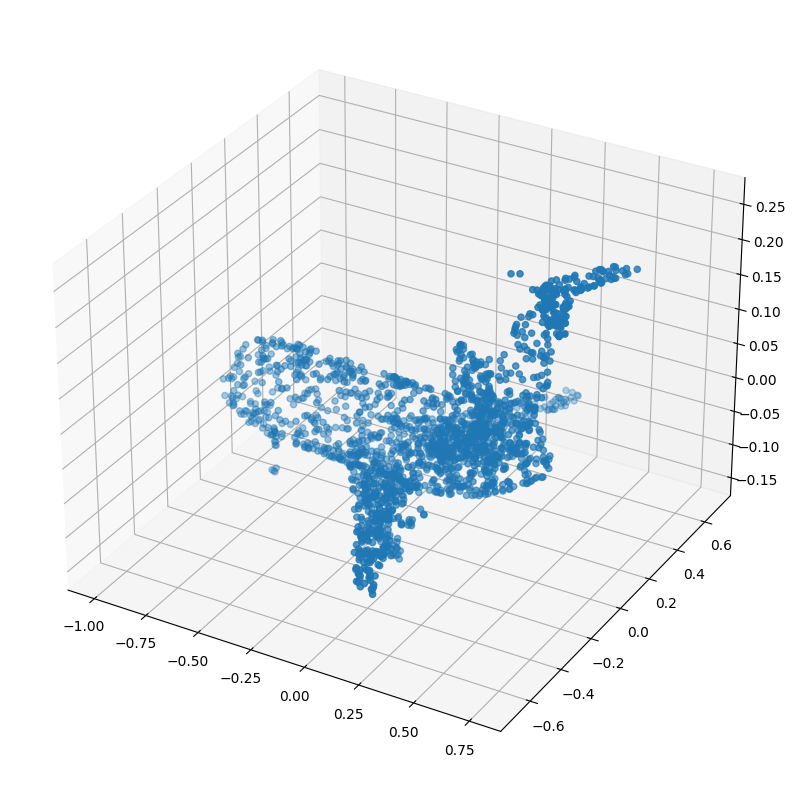

In [ ]:
# Dataset and dataloader
train_dataset = PointCloudDataset(TRAIN_DIR)
test_dataset = PointCloudDataset(TEST_DIR)

train_dataloader = DataLoader(train_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Let's take a look at a batch
batch_sample = next(iter(train_dataloader))
print(f"Batch shape: {batch_sample.shape}")
print(f"Batch type: {batch_sample.dtype}")
print(f"Batch device: {batch_sample.device}")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter_sample = batch_sample[0].cpu()
ax.scatter(scatter_sample[:, 0], scatter_sample[:, 1], scatter_sample[:, 2])


In [ ]:
# Figure out max, min, mean and standard deviation of x, y, z coordinates
def compute_mean_and_std(dataloader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    _max = torch.zeros(3)
    _min = torch.zeros(3)
    for batch in dataloader:
        mean += batch.mean(1).squeeze().mean(0)
        std += batch.std(1).squeeze().mean(0)
        _max += batch.max(1).values.squeeze().max(0).values
        _min += batch.min(1).values.squeeze().min(0).values

    # Divide by number of batches
    mean /= len(dataloader)
    std /= len(dataloader)
    _max /= len(dataloader)
    _min /= len(dataloader)
    return mean, std, _max, _min


mean, std, _max, _min = compute_mean_and_std(train_dataloader)
print(f"Mean: {mean}")
print(f"Std: {std}")
print(f"Max: {_max}")
print(f"Min: {_min}")


Mean: tensor([ 8.1195e-04,  7.4740e-05, -4.1769e-05], device='cuda:0')
Std: tensor([0.4207, 0.2603, 0.0813], device='cuda:0')
Max: tensor([0.9949, 0.9891, 0.4823], device='cuda:0')
Min: tensor([-1.0000, -0.9883, -0.2531], device='cuda:0')
